## We need to find set of REs that:
1. one of the REs must cut human mtDNA only one time
2. other REs must not cut mtDNA but must cut nuclear DNA to pieces less than 3-5kb

In [26]:
import re
import os
import random
import glob
from collections import Counter
from multiprocessing import Pool
from typing import Dict, List, Any
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
from Bio.Restriction import Analysis, AllEnzymes, RestrictionBatch
from Bio.Restriction.Restriction import RestrictionType
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import tqdm

import warnings
warnings.filterwarnings("ignore")

In [11]:
PIECES_SIZE = 5000
PATH_TO_HUMAN_GENOME = "../data/external/GCF_000001405.40/ncbi_dataset/data/GCF_000001405.40/*.fna"
# PATH_TO_RE = "../data/processed/cuted_seqs_num.csv"
PATH_TO_REF_MT = "../data/external/NC_012920.1.fasta"
PATH_TO_SEQS_MT = "../data/raw/sequence.fasta"
PATH_TO_sibenzyme = "../data/external/sibenzyme.csv"

In [3]:
len(AllEnzymes)

978

In [12]:
# human_genome = SeqIO.parse(PATH_TO_HUMAN_GENOME, "fasta")
mt_seqs = SeqIO.parse(PATH_TO_SEQS_MT, "fasta")
ref_mt = next(SeqIO.parse(PATH_TO_REF_MT, "fasta"))
sibenzyme = pd.read_csv(PATH_TO_sibenzyme)
sibenzyme["RE"] = sibenzyme["RE"].str.replace(" ", "")

### Prepare table with description of REs

In [33]:
sibenzyme.head()

,RE,ID,Site,Packaging,Variant
0,AatII,E287,GACGT↑C / C↓TGCAG,250 е.а. 2500 е.а. 500 е.а.,mini Regular
1,AbsI,E535_,CC↑TCGAGG / GGAGCT↓CC,1000 е.а. 200 е.а.,Regular
2,Acc16I,E001,TGC↑GCA / ACG↓CGT,1000 е.а. 200 е.а.,Regular
3,Acc36I,E289,ACCTGC(N)4↑ / TGGACG(N)8↓,100 е.а. 500 е.а.,Regular
4,Acc65I,E003,G↑GTACC / CCATG↓G,1000 е.а. 500 е.а. 5000 е.а.,mini Regular Turbo


In [32]:
n = 0
for enz in sibenzyme["RE"].unique():
    try:
        x = AllEnzymes.get(enz)
        n += 1
    except:
        print(enz)
print(n)

# KroNI site lay in mt refseq => can't be used

KroNI
195


## Search the enzymes that don't cut mtDNA

In [5]:
def extract_RE_without_site_on_mt(rec: SeqRecord) -> List[Dict]:
    ana = Analysis(AllEnzymes, rec.seq, linear=False)
    data = []
    for restr_enz in ana.without_site():
        re_name = repr(restr_enz)
        one_data = {"RE": re_name, "SeqName": rec.description}
        data.append(one_data)
    return data

In [7]:
# 27 min and 10GB of RAM
threads = 24
with Pool(threads) as p:
    collection_of_pot_rs = p.map(extract_RE_without_site_on_mt, mt_seqs)

In [11]:
pot_rs = []
for xx in collection_of_pot_rs:
    for x in xx:
        pot_rs.append(x)

re_without_site = pd.DataFrame(pot_rs)
re_without_site.to_csv("../data/interim/re_without_site.csv", index=None)
re_without_site.head()

,RE,SeqName
0,ArsI,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...
1,BglII,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...
2,FspI,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...
3,PspOMII,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...
4,MteI,MK968879.1 Homo sapiens isolate YHL_TK036_F4b1...


In [16]:
re_maximal_subset = re_without_site.RE.value_counts().reset_index()
re_maximal_subset.columns = ["RE", "NotCuttedSeqsNum"]
re_maximal_subset["Percentage"] = re_maximal_subset.NotCuttedSeqsNum / len(collection_of_pot_rs) * 100
re_maximal_subset.to_csv("../data/processed/NotCuttedSeqsNum.csv", index=None)
re_maximal_subset.head()

,RE,NotCuttedSeqsNum,Percentage
0,Sse232I,56445,100.0
1,SwaI,56445,100.0
2,Sse8387I,56445,100.0
3,MreI,56445,100.0
4,MauBI,56445,100.0


## Search of minimal subset of REs that destroy muclear DNA

1. initially need to add to the set ClaI, as RE that cut mtDNA only one time
2. drop RE dublicates
3. apply approach from GO hw2

In [34]:
re_maximal_subset = pd.read_csv("../data/processed/NotCuttedSeqsNum.csv")
re_maximal_subset

,RE,NotCuttedSeqsNum,Percentage
0,Sse232I,56445,100.000000
1,SwaI,56445,100.000000
2,Sse8387I,56445,100.000000
3,MreI,56445,100.000000
4,MauBI,56445,100.000000
...,...,...,...
255,Cma23826I,1,0.001772
256,Acc65V,1,0.001772
257,PpiP13II,1,0.001772
258,Sse8647I,1,0.001772


In [59]:
# We have a lot of potential REs
re_maximal_subset[(re_maximal_subset.RE.isin(sibenzyme.RE)) & (re_maximal_subset.Percentage > 99.5)]

,RE,NotCuttedSeqsNum,Percentage
8,AbsI,56445,100.000000
9,SmiI,56445,100.000000
10,SbfI,56445,100.000000
11,PalAI,56445,100.000000
13,CciNI,56445,100.000000
17,AsiSI,56444,99.998228
18,RigI,56444,99.998228
19,RgaI,56444,99.998228
24,MluI,56440,99.991142
27,Rsr2I,56434,99.980512


In [35]:
def collect_isoschizomers(enzymes: RestrictionBatch) -> List[List[str]]:
    """Search and collect all isoschizomers in passed enzymes"""
    data = []
    visited = set()
    for RE in enzymes:
        if repr(RE) in visited:
            continue

        visited.add(repr(RE))
        isosh_names = []
        for isosh in RE.isoschizomers():
            visited.add(repr(isosh))
            isosh_names.append(repr(isosh))
        data.append([repr(RE)] + isosh_names)
    return data


# # collect full collection of isoschizomers
# full_isosh = collect_isoschizomers(AllEnzymes)
# with open("../data/processed/full_isoschizomers.txt", "w") as fout:
#     for batch in full_isosh:
#         fout.write(",".join(batch) + "\n")

In [62]:
# sample RE that don't cut most of mtDNA
cutoff = 99.5 # %
REs_without_site_on_mt = re_maximal_subset[
    (re_maximal_subset.Percentage > cutoff)].RE.values
print(REs_without_site_on_mt.shape)

# create sample batch (custom data structure)
ClaI = AllEnzymes.get("ClaI")
excess_maximal_subset = RestrictionBatch(list(REs_without_site_on_mt) + ["ClaI"])
excess_maximal_subset

(78,)


RestrictionBatch(['AbsI', 'AcvI', 'AdeI', 'AgeI', 'ArsI', 'AscI', 'AsiGI', 'AsiSI', 'AspJHL3II', 'BbrPI', 'BoxI', 'BsePI', 'BshTI', 'Bsp460III', 'Bsp68I', 'BspGI', 'BssHII', 'BstPAI', 'BtuMI', 'CciNI', 'Cfr9I', 'ClaI', 'CpoI', 'CspAI', 'CspI', 'DraIII', 'Ecl35734I', 'Eco72I', 'FseI', 'FspAI', 'GauT27I', 'Lmo370I', 'MauBI', 'McaTI', 'MluI', 'MreI', 'MspSC27II', 'MteI', 'NotI', 'NpeUS61II', 'NruI', 'PalAI', 'PauI', 'PinAI', 'Ple19I', 'PmaCI', 'PmlI', 'PshAI', 'PspCI', 'PspXI', 'Pst273I', 'PteI', 'PvuI', 'RgaI', 'RigI', 'RpaB5I', 'RruI', 'Rsr2I', 'RsrII', 'SbfI', 'SdaI', 'SfaAI', 'SfiI', 'SgfI', 'SgrDI', 'SgsI', 'SmaI', 'SmiI', 'SrfI', 'Sse232I', 'Sse8387I', 'Ssp714II', 'SstE37I', 'Sth20745III', 'SwaI', 'TspARh3I', 'TspMI', 'UbaF13I', 'XmaI'])

In [63]:
# collect collection of isoschizomers for used sample REs
sufficient_sample = []
full_isosh = collect_isoschizomers(excess_maximal_subset)
with open(f"../data/processed/used_re_isoschizomers_{cutoff}%.txt", "w") as fout:
    for batch in full_isosh:
        sufficient_sample.append(batch[0])
        fout.write(",".join(batch) + "\n")

print(len(sufficient_sample))
maximal_subset = RestrictionBatch(sufficient_sample)
maximal_subset

42


RestrictionBatch(['AbsI', 'AcvI', 'AgeI', 'ArsI', 'AsiSI', 'AspJHL3II', 'Bsp460III', 'BspGI', 'BstPAI', 'CciNI', 'Cfr9I', 'ClaI', 'CspI', 'DraIII', 'Ecl35734I', 'FseI', 'FspAI', 'GauT27I', 'Lmo370I', 'MauBI', 'MluI', 'MreI', 'MspSC27II', 'MteI', 'NpeUS61II', 'PalAI', 'PauI', 'PspXI', 'Pst273I', 'PvuI', 'RpaB5I', 'RruI', 'SfiI', 'SgrDI', 'SmiI', 'SrfI', 'Sse8387I', 'Ssp714II', 'SstE37I', 'Sth20745III', 'TspARh3I', 'UbaF13I'])

In [38]:
def collect_cutpos(record: SeqRecord) -> List[Dict[str, Any]]:
    seq_str = str(record.seq)
    ana = Analysis(maximal_subset, record.seq)
    data_cutpos = []
    for enzyme, positions in ana.with_sites().items():
        for pos in positions:
            data_cutpos.append({
                "Record": record.description,
                "Pos": pos,
                "RE": repr(enzyme), 
            })
    return data_cutpos


# def extract_intervals_from_one_seq(rec_cutpos_df, seq: str):
    # assert rec_cutpos_df.Record.nunique() == 1
    # name = rec_cutpos_df.Record.values[0]
    
def extract_intervals_from_one_record(record: SeqRecord, cutpos: pd.DataFrame):
    data_intervals = []
    seq = str(record.seq)
    name = record.description
    rec_cutpos_df = cutpos[cutpos["Record"] == record.description]
    rec_cutpos_df.sort_values("Pos", inplace=True)
    rec_cutpos_df.reset_index(drop=True, inplace=True)
    
    if rec_cutpos_df.shape[0] == 0:
        Ncount = seq.count("N")
        data_intervals.append({
            "Record": name,
            "Begin": 0,
            "End": len(seq),
            "Lenght": len(seq),
            "Ncount": Ncount,
        })
        return data_intervals

    beg = 0
    prev_RE = None
    for i, row in rec_cutpos_df.iterrows():
        end = row.Pos
        interval = seq[beg: end]
        Ncount = interval.count("N") if len(interval) > 5000 else None
        data_intervals.append({
            "Record": name,
            "Begin": beg,
            "End": end,
            "REbegin": prev_RE,
            "REend": row.RE,
            "Lenght": end - beg,
            "Ncount": Ncount,
        })
        beg = end
        prev_RE = row.RE

    # last interval
    end = len(seq)
    interval = seq[beg: end]
    Ncount = interval.count("N") if len(interval) > 5000 else None
    data_intervals.append({
        "Record": name,
        "Begin": beg,
        "End": end,
        "REbegin": prev_RE,
        "REend": None,
        "Lenght": end - beg,
        "Ncount": Ncount,
    })
    return data_intervals


def iterate_over_records(indir: str) -> SeqRecord:
    for fp in glob.glob(os.path.join(indir, "*.fna")):
        for record in SeqIO.parse(fp, format="fasta"):
            yield record

In [20]:
# 6.5 min and 15GB of RAM
if False:
    threads = 24
    human_genome = iterate_over_records("../data/external/GCF_000001405.40/ncbi_dataset/data/GCF_000001405.40/")
    with Pool(threads) as p:
        pre_data_cutpos = p.map(collect_cutpos, human_genome)

    data_cutpos = []
    for xx in pre_data_cutpos:
        for x in xx:
            data_cutpos.append(x)

    cutpos = pd.DataFrame(data_cutpos)
    cutpos.to_csv("../data/interim/cutpos.csv", index=None)

In [39]:
cutpos = pd.read_csv("../data/interim/cutpos.csv")
cutpos.head()

,Record,Pos,RE
0,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",18626805,NotI
1,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",18646568,NotI
2,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",19097546,NotI
3,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",19302476,NotI
4,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",19668482,NotI


In [40]:
cutpos.RE.nunique()

42

In [88]:
data_intervals = []
threads = 24
human_genome = iterate_over_records("../data/external/GCF_000001405.40/ncbi_dataset/data/GCF_000001405.40/")
with Pool(threads) as p:
    pre_data_intervals = p.map(partial(extract_intervals_from_one_record, cutpos=cutpos), human_genome)

In [89]:
data_intervals = []
for xx in pre_data_intervals:
    for x in xx:
        data_intervals.append(x)

intervals = pd.DataFrame(data_intervals)
intervals["Nshare"] = (intervals.Ncount / intervals.Lenght).fillna(0)
intervals["ExNLen"] = (intervals.Lenght - intervals.Ncount).fillna(0)

In [122]:
intervals

,Record,Begin,End,REbegin,REend,Lenght,Ncount,Nshare,ExNLen
0,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",0,16000812,None,BbrPI,16000812,16000000.0,0.999949,812.0
1,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16000812,16000815,BbrPI,DraIII,3,NaN,0.000000,0.0
2,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16000815,16001785,DraIII,Ecl35734I,970,NaN,0.000000,0.0
3,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16001785,16003465,Ecl35734I,ArsI,1680,NaN,0.000000,0.0
4,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16003465,16003497,ArsI,ArsI,32,NaN,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
7108838,NT_113948.1 Homo sapiens chromosome 5 unlocali...,81897,82483,ArsI,BoxI,586,NaN,0.000000,0.0
7108839,NT_113948.1 Homo sapiens chromosome 5 unlocali...,82483,84727,BoxI,BbrPI,2244,NaN,0.000000,0.0
7108840,NT_113948.1 Homo sapiens chromosome 5 unlocali...,84727,84882,BbrPI,BsePI,155,NaN,0.000000,0.0
7108841,NT_113948.1 Homo sapiens chromosome 5 unlocali...,84882,86941,BsePI,BbrPI,2059,NaN,0.000000,0.0


In [124]:
intervals[
    (intervals.ExNLen > 5000)
].sort_values("Lenght")#.Ncount.sum()

,Record,Begin,End,REbegin,REend,Lenght,Ncount,Nshare,ExNLen
5431306,"NC_000005.10 Homo sapiens chromosome 5, GRCh38...",165502885,165507886,Ecl35734I,SmiI,5001,0.0,0.000000,5001.0
5309774,"NC_000005.10 Homo sapiens chromosome 5, GRCh38...",110806803,110811806,Ecl35734I,BoxI,5003,0.0,0.000000,5003.0
2674478,"NC_000001.11 Homo sapiens chromosome 1, GRCh38...",39148585,39153588,DraIII,BbrPI,5003,0.0,0.000000,5003.0
1548320,"NC_000011.10 Homo sapiens chromosome 11, GRCh3...",97100745,97105749,Pst273I,BspGI,5004,0.0,0.000000,5004.0
1425742,"NC_000011.10 Homo sapiens chromosome 11, GRCh3...",48574347,48579351,DraIII,SstE37I,5004,0.0,0.000000,5004.0
...,...,...,...,...,...,...,...,...,...
2333206,"NC_000009.12 Homo sapiens chromosome 9, GRCh38...",44134199,44228969,DraIII,Ecl35734I,94770,0.0,0.000000,94770.0
3960229,"NC_000002.12 Homo sapiens chromosome 2, GRCh38...",90402330,91414340,MluI,PspXI,1012010,1000000.0,0.988133,12010.0
2333359,"NC_000009.12 Homo sapiens chromosome 9, GRCh38...",45514486,60519593,Ecl35734I,BoxI,15005107,15000000.0,0.999660,5107.0
2864828,"NC_000001.11 Homo sapiens chromosome 1, GRCh38...",125183279,143188636,ClaI,ClaI,18005357,18000000.0,0.999702,5357.0


In [87]:
intervals[(intervals.Lenght > 5000) & (intervals.Nshare <= 0.8)].sort_values("Nshare").tail(20)  #.to_csv("../data/interim/blabla.csv", index=None)

,Record,Begin,End,REbegin,REend,Lenght,Ncount,Nshare
1768671,NT_187420.1 Homo sapiens unplaced genomic scaf...,60185,69131,ClaI,ClaI,8946,4416.0,0.493628
3269312,"NC_000006.12 Homo sapiens chromosome 6, GRCh38...",61353970,61364881,Ecl35734I,BspGI,10911,6037.0,0.553295
4451193,"NC_000007.14 Homo sapiens chromosome 7, GRCh38...",61961982,61967166,DraIII,DraIII,5184,2894.0,0.558256
1768650,NT_187420.1 Homo sapiens unplaced genomic scaf...,3972,11937,Ecl35734I,BspGI,7965,4702.0,0.590333
283646,"NC_000020.11 Homo sapiens chromosome 20, GRCh3...",28887102,28897194,DraIII,Ecl35734I,10092,6047.0,0.599187
2107327,"NC_000018.10 Homo sapiens chromosome 18, GRCh3...",20562080,20573191,UbaF13I,Ecl35734I,11111,6752.0,0.607686
2333154,"NC_000009.12 Homo sapiens chromosome 9, GRCh38...",43374979,43382765,BspGI,Ecl35734I,7786,4826.0,0.619830
5188355,"NC_000005.10 Homo sapiens chromosome 5, GRCh38...",49661096,49668112,PspXI,BspGI,7016,4402.0,0.627423
6234021,NT_187384.1 Homo sapiens chromosome 17 unlocal...,12069,22150,XmaI,Ecl35734I,10081,6504.0,0.645174
6234018,NT_187384.1 Homo sapiens chromosome 17 unlocal...,5298,11304,PspXI,XmaI,6006,3901.0,0.649517


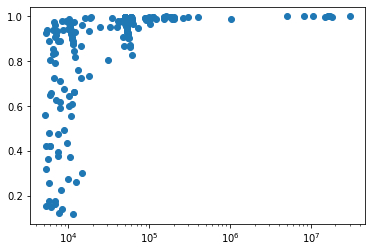

In [61]:
plt.scatter(intervals[intervals.Nshare > 0.1].Lenght, intervals[intervals.Nshare > 0.1].Nshare)
plt.xscale("log");

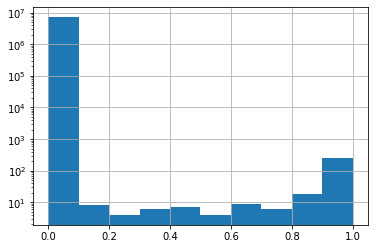

In [56]:
intervals.Nshare.hist()
plt.yscale("log")

In [44]:
intervals[intervals.N].sort_values("Lenght").tail(100)

,Record,Begin,End,REbegin,REend,Lenght,Ncount
795088,"NC_000023.11 Homo sapiens chromosome X, GRCh38...",62412138,62463947,DraIII,DraIII,51809,50000.0
2341796,"NC_000009.12 Homo sapiens chromosome 9, GRCh38...",65323527,65375422,DraIII,Ecl35734I,51895,50000.0
287662,"NC_000020.11 Homo sapiens chromosome 20, GRCh3...",31001233,31053139,SstE37I,Ecl35734I,51906,50000.0
2022417,"NC_000024.10 Homo sapiens chromosome Y, GRCh38...",9057198,9109110,Ecl35734I,ArsI,51912,50000.0
2365,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",18172920,18224875,Ecl35734I,UbaF13I,51955,50000.0
...,...,...,...,...,...,...,...
0,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",0,16000812,None,BbrPI,16000812,16000000.0
6897772,"NC_000013.11 Homo sapiens chromosome 13, GRCh3...",0,16000812,None,BbrPI,16000812,16000000.0
5918554,"NC_000015.10 Homo sapiens chromosome 15, GRCh3...",0,17000067,None,DraIII,17000067,17000000.0
2864828,"NC_000001.11 Homo sapiens chromosome 1, GRCh38...",125183279,143188636,ClaI,ClaI,18005357,18000000.0


In [54]:
record

SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN'), id='NC_000014.9', name='NC_000014.9', description='NC_000014.9 Homo sapiens chromosome 14, GRCh38.p14 Primary Assembly', dbxrefs=[])

In [49]:
ana = Analysis(maximal_subset, record.seq)

In [50]:
data = []
for enzyme, positions in ana.with_sites().items():
    for pos in positions:
        data.append({"RE": repr(enzyme), "Pos": pos})
cutpos = pd.DataFrame(data).sort_values("Pos")
cutpos.reset_index(drop=True, inplace=True)
cutpos.to_csv("../data/interim/Chr1_cutpos.csv", index=None)
cutpos

,RE,Pos
0,AcvI,16000812
1,DraIII,16000815
2,Ecl35734I,16001785
3,ArsI,16003465
4,ArsI,16003497
...,...,...
213518,PteI,106883553
213519,BoxI,106883621
213520,AspJHL3II,106883656
213521,UbaF13I,106883659


In [51]:
cutpos = pd.read_csv("../data/interim/Chr1_cutpos.csv")
cutpos

,RE,Pos
0,AcvI,16000812
1,DraIII,16000815
2,Ecl35734I,16001785
3,ArsI,16003465
4,ArsI,16003497
...,...,...
213518,PteI,106883553
213519,BoxI,106883621
213520,AspJHL3II,106883656
213521,UbaF13I,106883659


In [67]:
data = []
intervals = []
beg = 0
prev_RE = None
for i, row in cutpos.iterrows():
    end = row.Pos
    interval = seq_str[beg: end]
    if len(interval) > 5000:
        Ncount = interval.count("N") if "N" in interval else 0
    else:
        Ncount = None
    data.append({
        "Record": record.description,
        "Begin": beg,
        "End": end,
        "REbegin": prev_RE,
        "REend": row.RE,
        "Lenght": end - beg,
        "Ncount": Ncount,
    })
    beg = end
    prev_RE = row.RE

end = len(record)
interval = seq_str[beg: end]
if len(interval) > 5000:
    Ncount = interval.count("N") if "N" in interval else 0
else:
    Ncount = None
data.append({
    "Record": record.description,
    "Begin": beg,
    "End": end,
    "REbegin": prev_RE,
    "REend": None,
    "Lenght": end - beg,
    "Ncount": Ncount,
})

df = pd.DataFrame(data)

In [69]:
df.sort_values("Lenght", ascending=False).head(30)

,Record,Begin,End,REbegin,REend,Lenght,Ncount
0,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",0,16000812,None,AcvI,16000812,16000000.0
213523,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",106883687,107043718,MreI,None,160031,160000.0
3215,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",18712272,18862751,SmiI,Ecl35734I,150479,150000.0
4976,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",19511251,19611786,Cfr9I,BspGI,100535,100000.0
2358,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",18172920,18224875,Ecl35734I,UbaF13I,51955,50000.0
185,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16102253,16117148,BspGI,ArsI,14895,7856.0
25707,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",29124968,29133460,SmiI,BspGI,8492,0.0
161,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16068801,16077232,DraIII,SstE37I,8431,0.0
179,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",16085223,16092685,ArsI,Ecl35734I,7462,2937.0
143299,"NC_000014.9 Homo sapiens chromosome 14, GRCh38...",83193477,83200664,Cfr9I,BspGI,7187,0.0


In [ ]:
# for fp in glob.glob("../data/external/GCF_000001405.40/ncbi_dataset/data/GCF_000001405.40/*.fna"):
#     if "chrMT" in fp:
#         continue
    
#     for record in SeqIO.parse(fp, format="fasta"):
#         for partof_chr in re.split("N{50,}", record):
#             if "mt" in partof_chr.description.lower():
#                 continue
#             ana = Analysis(maximal_subset, partof_chr.seq)
#             for enzyme, positions in ana.with_sites().items():
#                 # use values to sort and write to table
#                 # after that analize table and create subset
#                 pass
            

#         break